In [1]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
%cd /home/jx8fh/Projects/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# USE GPU 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import json
config_fname = 'configs/ours-LaMoD.json'
config = json.load(open(config_fname))

In [4]:
from models.LaMoD import LaMoD
network = LaMoD(config['networks'], device).to(device)

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': True, 'pretrained_model_path': 'checkpoints/ours_motion_regression.pth'}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
Loading pretrained model from checkpoints/ours_motion_regression.pth


# CINE

In [5]:
cine_DENSE_fname = '/scratch/jx8fh/2024-04-21-matched-cine-DENSE-from-Yu-all-with-resampled.npy'
cine_DENSE_data = np.load(cine_DENSE_fname, allow_pickle=True).tolist()

In [6]:
print(f"length of data: {len(cine_DENSE_data)}")
check_dict(cine_DENSE_data[0])

length of data: 105
AnalysisInfo                                                 dict_keys(['ResampleMethod', 'ResampleDistance', 'SpatialSmoothing', 'TemporalOrder', 'Xseed', 'Yseed', 'Zseed', 'FramesForAnalysis', 'Nmodel', 'PositionA', 'PositionB', 'Clockwise'])
AnalysisInstanceUID                                          1.3.6.1.4.1.9590.100.1.2.64946301013757307506911904523491151334
DENSEInfo                                                    dict_keys(['Name', 'UID', 'Type', 'MagIndex', 'PhaIndex', 'Number', 'PixelSpacing', 'Scale', 'EncFreq', 'SwapFlag', 'NegFlag'])
DENSE_Eul_displacement_field_Multipliers                     (3,)                
DENSE_Eul_displacement_field_X                               (48, 48, 51)        
DENSE_Eul_displacement_field_Y                               (48, 48, 51)        
DENSE_Lag_displacement_field_X                               (48, 48, 51)        
DENSE_Lag_displacement_field_Y                               (48, 48, 51)        
DENSE_frame

In [7]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain
from modules.data.processing.strain_analysis.resample_strain_matrix import resample_strain_matrix_2d
from modules.data.processing.strain_analysis.six_segments_core import six_segments_core, get_various_segmental_strain_data
from skimage.transform import resize
from skimage.morphology import dilation, disk, closing
import tqdm
# check_data_idx = 0
n_repeats = 10
my_pred_disps = []
skip_diffusion = True
for check_data_idx, check_datum in tqdm.tqdm(enumerate(cine_DENSE_data)):
    # if check_data_idx == 0:
    #     continue
    # for skip_diffusion in [True, False]:
    # for skip_diffusion in [False]:
    # for skip_diffusion in [False, True]:
    inference_mask_raw = torch.from_numpy(
            resize(check_datum['cine_cropped_myocardium_masks_rescaled_1mm2'][...,0]>0.5, [48,48], anti_aliasing=False)
        )
    # if check_data_idx == 0:        
    #     inference_mask = torch.from_numpy(dilation(inference_mask_raw, disk(2)))
    # else:
    inference_mask = torch.from_numpy(dilation(inference_mask_raw, disk(2)))
    # inference_mask = inference_mask_raw
    # Prepare Pytorch tensor
    inference_input_video      = torch.from_numpy(check_datum['cine_cropped_myocardium_masks_rescaled_1mm2']).to(device).moveaxis(-1,0)[None, None]
    # inference_input_video_ori_frame = check_datum['ori_n_frames']
    inference_input_video_ori_frame = inference_input_video.shape[2]

    # break
    if skip_diffusion is True:
        inference_output_dict = network.inference(
            inference_input_video, 
            ori_n_frames=[inference_input_video_ori_frame],
            skip_diffusion=True)[0]
        # Extract prediction
        inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73
        
    else:
        inference_disp_repeats = []
        for repeat_idx in range(n_repeats):
            curr_inference_output_dict = network.inference(
                inference_input_video, 
                ori_n_frames=[inference_input_video_ori_frame],
                skip_diffusion=False)[0]

            # Extract prediction
            curr_inference_disp = curr_inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73
            inference_disp_repeats.append(curr_inference_disp)
        inference_disp = sum(inference_disp_repeats) / n_repeats
        # raise Error('Dontt use this')            
    

    H, W = inference_disp.shape[-2:]
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    dXt = np.moveaxis(inference_disp[0,0].numpy(), 0, -1)
    dYt = np.moveaxis(inference_disp[0,1].numpy(), 0, -1)
    mask = inference_mask.numpy()
    Nfr = inference_disp.shape[2]
    strain = pixelstrain(
        X=X, Y=Y, 
        dXt=dXt, dYt=dYt, 
        mask=mask, times=np.arange(Nfr))
    strainCC = strain['CC']
    # for frame_idx in range(strainCC.shape[-1]):
    #     strainCC[...,frame_idx][inference_mask_raw<0.5] = np.nan
        # inference_disp[0,0,frame_idx][inference_mask_raw<0.5] = np.nan
        # inference_disp[0,0,frame_idx][inference_mask_raw<0.5] = np.nan
    break
    my_pred_disps.append(inference_disp)
    if skip_diffusion:
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-SkipDiffusion-Disp.npy', inference_disp)
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-SkipDiffusion-EccVol.npy', strainCC)
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-SkipDiffusion-mask.npy', inference_mask)
    else:
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-Avg5Diffusion-Disp.npy', inference_disp)
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-Avg5Diffusion-EccVol.npy', strainCC)
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-Avg5Diffusion-mask.npy', inference_mask)
        # break
    # break

0it [00:10, ?it/s]


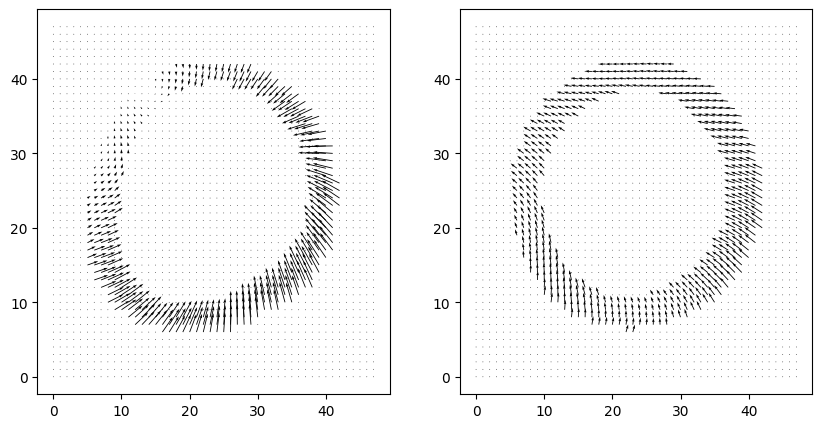

In [8]:
# Visualize 
check_frame_idx = 10
fig, axs = plt.subplots(1, 2, figsize=(10,5))
# Prediction
axs[0].quiver(
    inference_disp[0,0,check_frame_idx]*inference_mask_raw,
    inference_disp[0,1,check_frame_idx]*inference_mask_raw,
    units='xy',
    scale=1
)
# DENSE GT
axs[1].quiver(
    cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_X'][...,check_frame_idx],
    cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_Y'][...,check_frame_idx],
    units='xy',
    scale=1
)

In [24]:
inference_disp.shape

torch.Size([1, 2, 19, 48, 48])

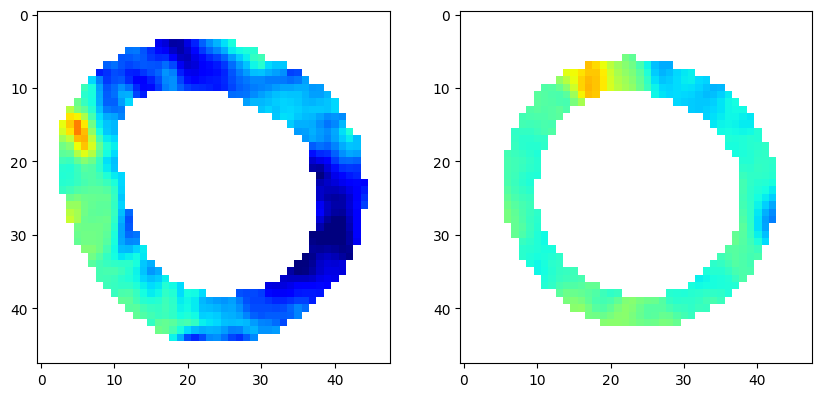

In [21]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain
import copy
H, W = inference_disp.shape[-2:]
X, Y = np.meshgrid(np.arange(W), np.arange(H))
dXt = np.moveaxis(inference_disp[0,0].numpy(), 0, -1)
dYt = np.moveaxis(inference_disp[0,1].numpy(), 0, -1)
mask = inference_mask.numpy()
Nfr = inference_disp.shape[2]
strain = pixelstrain(
    X=X, Y=Y, 
    dXt=dXt, dYt=dYt, 
    mask=mask, 
    # post_processing_mask=inference_mask_raw.numpy(),
    times=np.arange(Nfr))
# inference_mask_raw_nan = copy.deepcopy(inference_mask_raw.numpy())
# inference_mask_raw_nan[inference_mask_raw_nan<0.5] = np.nan
# mask_GT = cine_DENSE_data[check_data_idx]['DENSE_myo_masks'][...,0]
Nfr_DENSE = cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_X'].shape[2]
mask_GT = (np.abs(cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_X'][...,0]) + np.abs(cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_Y'][...,0])) > 0
strain_GT = pixelstrain(
    X=X, Y=Y, 
    dXt=cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_X'], 
    dYt=cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_Y'], 
    mask=mask_GT, times=np.arange(Nfr_DENSE))
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(strain['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)
axs[1].imshow(strain_GT['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)

In [23]:
cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_X'].shape

(48, 48, 51)

In [20]:
Nfr

19

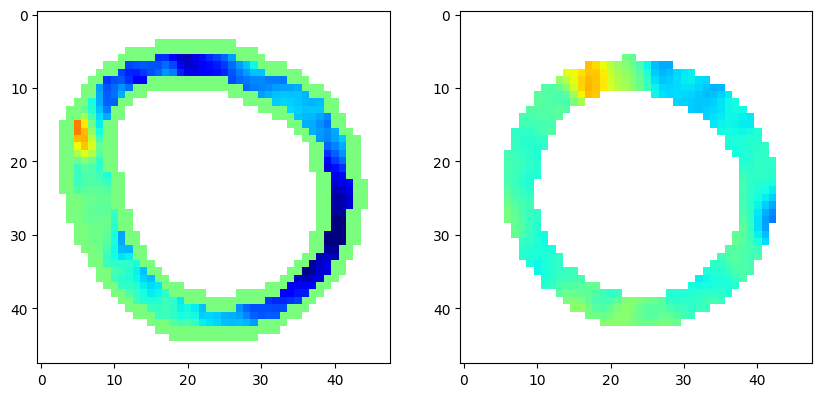

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(strain['CC'][...,check_frame_idx]*inference_mask_raw.numpy(), cmap='jet', vmin=-0.2, vmax=0.2)
axs[1].imshow(strain_GT['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)

In [15]:
data_recompute_strain_fname = '/scratch/jx8fh/2024-04-21-matched-cine-DENSE-from-Yu-all-recompute-strain.npy'
data_recompute_strain = np.load(data_recompute_strain_fname, allow_pickle=True).tolist()
check_dict(data_recompute_strain[0])

CCImg                                                        (48, 48, 51)        
CCImg_GT                                                     (128, 128, 51)      
DENSE_strain                                                 dict_keys(['origin', 'insertion', 'CCs4', 'CCs6', 'CCs18', 'Seg4', 'Seg6', 'Seg18', 'CCs4Resampled', 'CCs6Resampled', 'CCs18Resampled'])
Diffusion_cine_strain                                        dict_keys(['origin', 'insertion', 'CCs4', 'CCs6', 'CCs18', 'Seg4', 'Seg6', 'Seg18', 'CCs4Resampled', 'CCs6Resampled', 'CCs18Resampled'])
UNetR_cine_strain                                            dict_keys(['origin', 'insertion', 'CCs4', 'CCs6', 'CCs18', 'Seg4', 'Seg6', 'Seg18', 'CCs4Resampled', 'CCs6Resampled', 'CCs18Resampled'])
StrainNet_cine_strain                                        dict_keys(['origin', 'insertion', 'CCs4', 'CCs6', 'CCs18', 'Seg4', 'Seg6', 'Seg18', 'CCs4Resampled', 'CCs6Resampled', 'CCs18Resampled'])


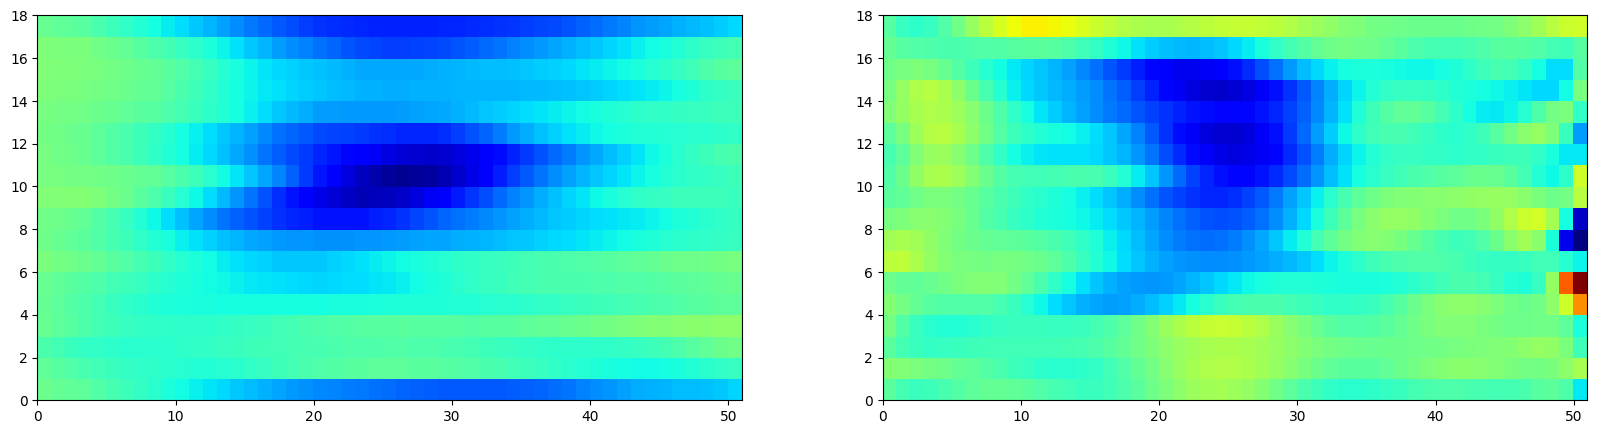

In [22]:
from modules.data.processing.strain_analysis.resample_strain_matrix import resample_strain_matrix_2d
from modules.data.processing.strain_analysis.six_segments_core import six_segments_core, get_various_segmental_strain_data

cine_datum_n_valid_frames = Nfr
DENSE_time_stamps = cine_DENSE_data[check_data_idx]['DENSE_frame_time_stamps']
cine_time_stamps = cine_DENSE_data[check_data_idx]['cine_frame_time_stamps'][:cine_datum_n_valid_frames]

# DENSE_strain_imgs = data_recompute_strain[check_data_idx]['CCImg']
DENSE_strain_imgs = strain_GT['CC']
DENSE_strain_mask = np.abs(cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_X'][...,0])>1e-5
DENSE_origin = cine_DENSE_data[check_data_idx]['AnalysisInfo']['PositionA'] - np.array([cine_DENSE_data[check_data_idx]['DENSE_myo_mask_bbox'][2], cine_DENSE_data[check_data_idx]['DENSE_myo_mask_bbox'][0]])
DENSE_insertion = cine_DENSE_data[check_data_idx]['AnalysisInfo']['PositionB'] - np.array([cine_DENSE_data[check_data_idx]['DENSE_myo_mask_bbox'][2], cine_DENSE_data[check_data_idx]['DENSE_myo_mask_bbox'][0]])
DENSE_recompute_strain = get_various_segmental_strain_data(
    DENSE_strain_imgs, 
    DENSE_strain_mask, 
    DENSE_origin, 
    DENSE_insertion,
    layerid_map = None,
    generate_layerid_map=True)

cine_recompute_strain = get_various_segmental_strain_data(
    strain_images=strain['CC'], 
    strain_mask=~np.isnan(strain['CC'][...,0]), 
    origin=np.array([24,24]), 
    # insertion=np.array([24,0]),
    insertion=cine_DENSE_data[check_data_idx]['cine_rv_insertion_points_rescaled_DENSE48'],
    enable_offset=True,
    offset_degrees=[90, 120, 120],
    generate_layerid_map=False)

for strainmat_name in ['CCs4', 'CCs6', 'CCs18']:
    DENSE_recompute_strain[strainmat_name+'Resampled'] = resample_strain_matrix_2d(DENSE_recompute_strain[strainmat_name], DENSE_time_stamps, cine_time_stamps)
    cine_recompute_strain[strainmat_name+'Resampled'] = resample_strain_matrix_2d(cine_recompute_strain[strainmat_name], cine_time_stamps, DENSE_time_stamps)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].pcolor(cine_recompute_strain['CCs18Resampled'], cmap='jet', vmin=-0.2, vmax=0.2)
axs[1].pcolor(data_recompute_strain[check_data_idx]['DENSE_strain']['CCs18'], cmap='jet', vmin=-0.2, vmax=0.2)

In [25]:
check_dict(cine_DENSE_data[check_data_idx])

AnalysisInfo                                                 dict_keys(['ResampleMethod', 'ResampleDistance', 'SpatialSmoothing', 'TemporalOrder', 'Xseed', 'Yseed', 'Zseed', 'FramesForAnalysis', 'Nmodel', 'PositionA', 'PositionB', 'Clockwise'])
AnalysisInstanceUID                                          1.3.6.1.4.1.9590.100.1.2.64946301013757307506911904523491151334
DENSEInfo                                                    dict_keys(['Name', 'UID', 'Type', 'MagIndex', 'PhaIndex', 'Number', 'PixelSpacing', 'Scale', 'EncFreq', 'SwapFlag', 'NegFlag'])
DENSE_Eul_displacement_field_Multipliers                     (3,)                
DENSE_Eul_displacement_field_X                               (48, 48, 51)        
DENSE_Eul_displacement_field_Y                               (48, 48, 51)        
DENSE_Lag_displacement_field_X                               (48, 48, 51)        
DENSE_Lag_displacement_field_Y                               (48, 48, 51)        
DENSE_frame_indices_with_myo_co

In [18]:
data_recompute_strain[check_data_idx]['CCImg'].shape

(48, 48, 51)

In [19]:
strain_GT['CC'].shape

(48, 48, 19)

# DENSE

In [50]:
# test_DENSE_data = np.load('/p/mmcardiac/Jerry/code/CINE-DENSE-Translation/data/DENSE/2024-04-16-test-data.npy', allow_pickle=True).tolist()
test_DENSE_data = np.load('/scratch/jx8fh/2024-04-16-test-data.npy', allow_pickle=True).tolist()
# test_DENSE_data = np.load('/scratch/jx8fh/2024-06-22-MICCAI-ShapeMI-Workshop-data/lamod_test.npy', allow_pickle=True).tolist()
print(f"len(test_DENSE_data) = {len(test_DENSE_data)}")
check_dict(test_DENSE_data[0])

len(test_DENSE_data) = 102
patient_id                                                   033                 
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/033_S01_base_auto.1_ROI.1.mat
DENSE_slice_location                                         76.947609505431     
DENSE_frame_time_stamps                                      (51,)               
DENSE_Lag_displacement_field_X                               (48, 48, 51)        
DENSE_Lag_displacement_field_Y                               (48, 48, 51)        
DENSE_myo_masks                                              (48, 48, 51)        
DENSE_myo_mask_bbox                                          (34, 82, 40, 88)    
DENSE_myo_masks_rescaled                                     (128, 128, 51)      
DENSE_n_frames_all                                           51                  
DENSE_frame_indices_with_myo_contour                         (51,)            

In [53]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain
from modules.data.processing.strain_analysis.resample_strain_matrix import resample_strain_matrix_2d
from modules.data.processing.strain_analysis.six_segments_core import six_segments_core, get_various_segmental_strain_data
from skimage.transform import resize
from skimage.morphology import dilation, disk, closing
import tqdm
# check_data_idx = 0
n_repeats = 10
my_pred_disps = []
skip_diffusion = True
for check_data_idx, check_datum in tqdm.tqdm(enumerate(test_DENSE_data)):
    # if check_data_idx == 0:
    #     continue
    # for skip_diffusion in [True, False]:
    # for skip_diffusion in [False]:
    # for skip_diffusion in [False, True]:
    inference_mask = torch.from_numpy(check_datum['DENSE_myo_masks'][...,0])
    # if check_data_idx == 0:        
    #     inference_mask = torch.from_numpy(dilation(inference_mask_raw, disk(2)))
    # else:
    # inference_mask = inference_mask_raw
    # Prepare Pytorch tensor
    inference_input_video      = torch.from_numpy(check_datum['DENSE_myo_masks_rescaled']).to(device).moveaxis(-1,0)[None, None]
    # inference_input_video_ori_frame = check_datum['ori_n_frames']
    inference_input_video_ori_frame = inference_input_video.shape[2]

    # break
    if skip_diffusion is True:
        inference_output_dict = network.inference(
            inference_input_video, 
            ori_n_frames=[inference_input_video_ori_frame],
            skip_diffusion=True)[0]
        # Extract prediction
        inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73
        
    else:
        inference_disp_repeats = []
        for repeat_idx in range(n_repeats):
            curr_inference_output_dict = network.inference(
                inference_input_video, 
                ori_n_frames=[inference_input_video_ori_frame],
                skip_diffusion=False)[0]

            # Extract prediction
            curr_inference_disp = curr_inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73
            inference_disp_repeats.append(curr_inference_disp)
        inference_disp = sum(inference_disp_repeats) / n_repeats
        # raise Error('Dontt use this')            
    

    H, W = inference_disp.shape[-2:]
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    dXt = np.moveaxis(inference_disp[0,0].numpy(), 0, -1)
    dYt = np.moveaxis(inference_disp[0,1].numpy(), 0, -1)
    mask = inference_mask.numpy()
    Nfr = inference_disp.shape[2]
    strain = pixelstrain(
        X=X, Y=Y, 
        dXt=dXt, dYt=dYt, 
        mask=mask, times=np.arange(Nfr))
    strainCC = strain['CC']
    # for frame_idx in range(strainCC.shape[-1]):
    #     strainCC[...,frame_idx][inference_mask_raw<0.5] = np.nan
        # inference_disp[0,0,frame_idx][inference_mask_raw<0.5] = np.nan
        # inference_disp[0,0,frame_idx][inference_mask_raw<0.5] = np.nan
    break
    my_pred_disps.append(inference_disp)
    if skip_diffusion:
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-SkipDiffusion-Disp.npy', inference_disp)
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-SkipDiffusion-EccVol.npy', strainCC)
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-SkipDiffusion-mask.npy', inference_mask)
    else:
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-Avg5Diffusion-Disp.npy', inference_disp)
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-Avg5Diffusion-EccVol.npy', strainCC)
        np.save(f'debug/notebooks/2024-11-20-debug-sona-data/LaMoD-slice{check_data_idx}-Avg5Diffusion-mask.npy', inference_mask)
        # break
    # break

0it [00:03, ?it/s]


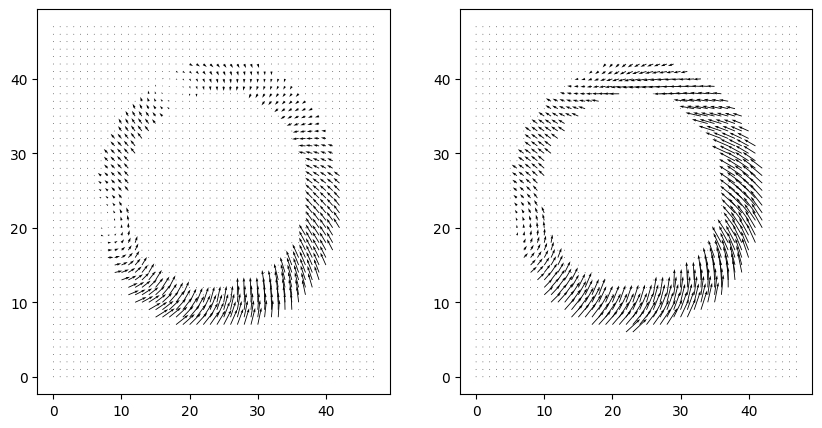

In [84]:
# Visualize 
check_frame_idx = 30
fig, axs = plt.subplots(1, 2, figsize=(10,5))
# Prediction
axs[0].quiver(
    inference_disp[0,0,check_frame_idx]*inference_mask,
    inference_disp[0,1,check_frame_idx]*inference_mask,
    units='xy',
    scale=1
)
# DENSE GT
axs[1].quiver(
    cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_X'][...,check_frame_idx],
    cine_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_Y'][...,check_frame_idx],
    units='xy',
    scale=1
)

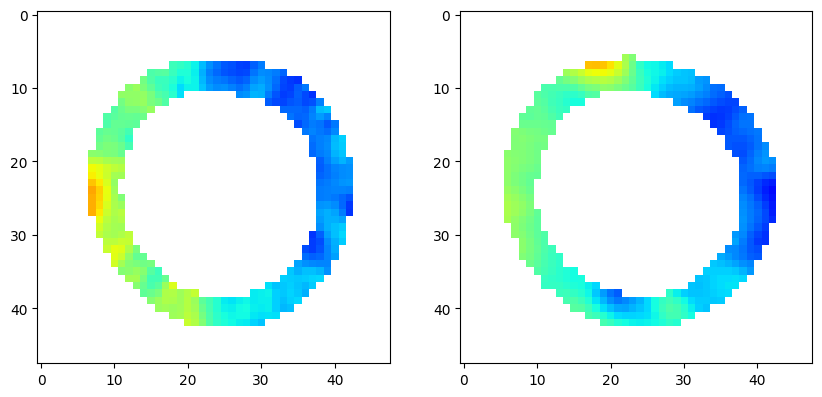

In [85]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain

H, W = inference_disp.shape[-2:]
X, Y = np.meshgrid(np.arange(W), np.arange(H))
dXt = np.moveaxis(inference_disp[0,0].numpy(), 0, -1)
dYt = np.moveaxis(inference_disp[0,1].numpy(), 0, -1)
mask = inference_mask.numpy()
Nfr = inference_disp.shape[2]
strain = pixelstrain(
    X=X, Y=Y, 
    dXt=dXt, dYt=dYt, 
    mask=mask, times=np.arange(Nfr))
# mask_GT = test_DENSE_data[check_data_idx]['DENSE_myo_masks'][...,0]
mask_GT = (np.abs(test_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_X'][...,0]) + np.abs(test_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_Y'][...,0])) > 0
strain_GT = pixelstrain(
    X=X, Y=Y, 
    dXt=test_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_X'], 
    dYt=test_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_Y'], 
    mask=mask_GT, times=np.arange(Nfr))
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(strain['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)
axs[1].imshow(strain_GT['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)

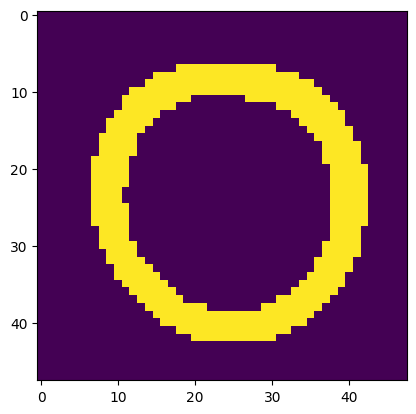

In [83]:
plt.imshow(test_DENSE_data[check_data_idx]['DENSE_myo_masks'][...,0])

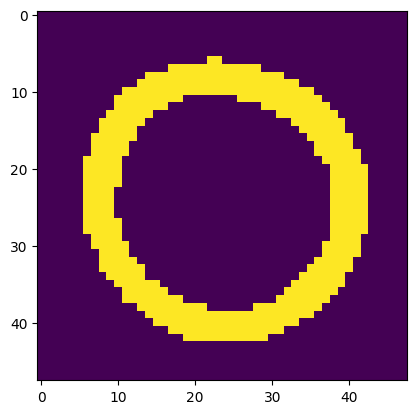

In [81]:
plt.imshow((np.abs(test_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_X'][...,0]) + np.abs(test_DENSE_data[check_data_idx]['DENSE_Lag_displacement_field_Y'][...,0])) > 0)

In [78]:
test_DENSE_data[check_data_idx]['DENSE_myo_masks'].shape

(48, 48, 51)

In [61]:
inference_disp.shape

torch.Size([1, 2, 50, 48, 48])

In [62]:
dXt.shape

(48, 48, 50)

In [63]:
np.moveaxis(test_data[check_data_idx]['DENSE_disp'][0], 0, -1).shape

(48, 48, 40)

In [56]:
check_frame_idx

10